### In this notebook I have covered Bert Model for data classification

I have used pretrained model 'bert-base-uncased' from Hugging Face https://huggingface.co/bert-base-uncased


The dataset used is from kaggle - https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

The data have been pre-processed for formating issue using re library.

I have also used examples from Live Customer interactions's with ChatBot application.

The Kaggle dataset contains 6 different concent moderation categories - toxic, severe_toxic, obscene threat, insult, identity_hate

I have created the model for identity_hate. Using identity_hate class helped in using the Real World data, as that data is tagged manually by our customer care representatives for this class making it available for evaluating the perforamnce of the model

In [112]:
# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast, TFAutoModel

# tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
import pandas as pd
import tensorflow as tf
import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn import set_config
set_config(display="diagram")

import warnings
warnings.filterwarnings("ignore")

In [27]:
train_table =pd.read_csv('data/train.csv')

In [28]:
df = train_table.query('identity_hate != 0')
df_n = train_table.query('identity_hate == 0')

<AxesSubplot:>

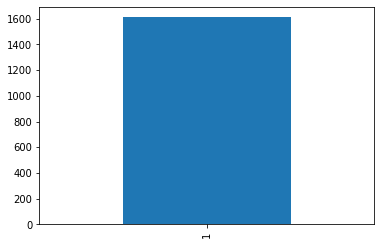

In [29]:
#Count of class identity_hate
df.identity_hate.value_counts().sort_values().plot(kind = 'bar')

<AxesSubplot:>

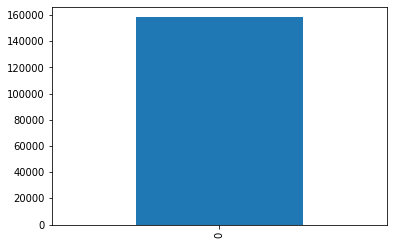

In [30]:
#Count of class non identity_hate
df_n.identity_hate.value_counts().sort_values().plot(kind = 'bar')

In [31]:
df = df.append(df_n[:2500])

<AxesSubplot:>

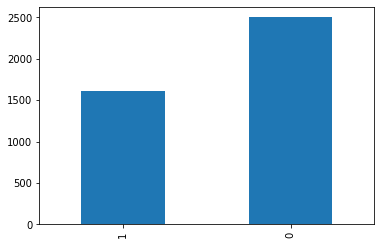

In [32]:
#Check for class imbalance now in the final dataset used for training
df.identity_hate.value_counts(normalize = True)
df.identity_hate.value_counts().sort_values().plot(kind = 'bar')

In [33]:
# The dataset contains other classes as well but we are building our model to identify only identity_hate class
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4110 entries, 42 to 2528
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             4110 non-null   object
 1   comment_text   4110 non-null   object
 2   toxic          4110 non-null   int64 
 3   severe_toxic   4110 non-null   int64 
 4   obscene        4110 non-null   int64 
 5   threat         4110 non-null   int64 
 6   insult         4110 non-null   int64 
 7   identity_hate  4110 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 289.0+ KB


## Data pre-processing

In [34]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [35]:
df['comment_text'] = df['comment_text'].map(lambda x : clean_text(x))


In [36]:
train_sentences = df["comment_text"].fillna("CVxTz").values
list_classes = [ "identity_hate"]
train_y = df[list_classes].values

In [37]:
train_sentences.shape


(4110,)

<class 'set'>


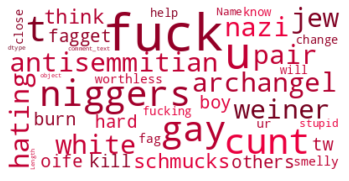

In [41]:
# world cloud for identity_hate class
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("RT")

print(type(STOPWORDS))

import random

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(df.loc[df["identity_hate"]==1].comment_text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

<class 'set'>


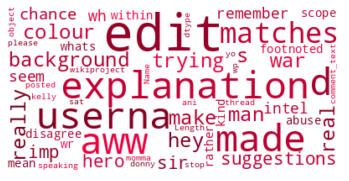

In [42]:
# world cloud for non identity_hate class

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("RT")

print(type(STOPWORDS))

import random

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(df.loc[df["identity_hate"]==0].comment_text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

## **Using the  bert-base-uncased  from Hugging Face https://huggingface.co/bert-base-uncased**

### Pretrained model on English language using a masked language modeling (MLM) objective. It was introduced in this paper  https://arxiv.org/abs/1810.04805 and first released in this repository https://github.com/google-research/bert . This model is uncased: it does not make a difference between english and English.


In [43]:
# Name of the BERT model to use
model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 128 # max 512

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
#config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
bert = TFAutoModel.from_pretrained(model_name)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [44]:
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32') 
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
x = bert.bert(inputs)

In [45]:
input_ids

<KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'input_ids')>

In [46]:
attention_mask

<KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'attention_mask')>

In [47]:
x

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert')>, pooler_output=<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'bert')>, past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)

In [48]:
x2 = GlobalAveragePooling1D()(x[0])
y =Dense(len(list_classes), activation='sigmoid', name='outputs')(x2)

model = Model(inputs=inputs, outputs=y)

# Take a look at the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [49]:
optimizer = Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [50]:
# Tokenize the input 
x = tokenizer(
    text=list(train_sentences),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [51]:
history = model.fit(
    x={'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']},
    #x={'input_ids': x['input_ids']},
    y={'outputs': train_y},
    validation_split=0.1,
    batch_size=32,
    epochs=1)

116/116 [==============================] - 2100s 18s/step - loss: 0.2177 - accuracy: 0.9086 - val_loss: 0.2323 - val_accuracy: 0.9173


### The val_accuracy is .9611 , which is better then the other model (Logistic Regression , Decision Tree ) we have trained earlier

## Testing the model on real world data
### I have taken examples from Live Customer interactions's with ChatBot application.
### Created two evaluation dataset
#### 1 - This has normal utterances Non identity_hate

#### 2 - This has utterances which were identified as egregious and fall under identity_hate class

### The dataset was manually tagged by our customer care representatives who interact with customers on a daily basis

In [95]:
# First loading the dataset with Normal utterances
eval_normal = pd.read_csv('data/evaluate_normal_utterances.csv')

In [96]:
eval_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Text           133 non-null    object
 1   identity_hate  133 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [97]:
eval_normal.head(3)

,Text,identity_hate
0,I need to cancel my last order! I dont know wh...,0
1,How do I cancel an automatic payment,0
2,How do I cancel the transfer,0


In [98]:
normal_test_sentences = eval_normal["Text"].fillna("CVxTz").values
list_classes = [ "identity_hate"]
normal_test_y = eval_normal[list_classes].values

In [99]:
norm_test_x = tokenizer(
    text=list(normal_test_sentences),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length', # padding=True initial value,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [100]:
norm_results = model.predict(x={'input_ids': norm_test_x['input_ids'], 'attention_mask': norm_test_x['attention_mask']},
                             batch_size=32)

5/5 [==============================] - 13s 2s/step


In [101]:
df_normal = pd.DataFrame(norm_results,columns = ['prediction'])
df_normal.head()

,prediction
0,0.004351
1,0.005344
2,0.001893
3,0.002585
4,0.009959


## Using threshold as .80
#### prediction >= .80  -> considered egregious (identity_hate)
#### prediction <.80 -> considered egregious ( non identity_hate)

### I have used high threashould to reduce False Positives.

In [102]:
## The model is correctly able to predict the normal sentences - none of the sentences were identified 
## as containing identity hate which matches with the manual tagging
for k in  df_normal.index:
  if(df_normal['prediction'][k] < .80):
    df_normal['prediction'][k] = 0
  else:
    df_normal['prediction'][k] = 1
df_normal.head()

,prediction
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [103]:
# Now loading the dataset with Egregious utterances
eval_egregious = pd.read_csv('data/evaluate_egregious_utterances.csv')
eval_egregious.head(3)

,Text,identity_hate
0,remove the fucking cunt put a fucking person o...,1
1,you fucking cunt answered get on the fucking line,1
2,i received an e_mail from you whore @side_spee...,1


In [104]:
eval_egregious['Text'] = eval_egregious['Text'].map(lambda x : clean_text(x))

In [105]:
egregious_test_sentences = eval_egregious["Text"].fillna("CVxTz").values
list_classes = [ "identity_hate"]
egregious_test_y = eval_egregious[list_classes].values

In [106]:
egregious_test_x = tokenizer(
    text=list(egregious_test_sentences),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length', # padding=True initial value,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [107]:
egregious_results = model.predict(x={'input_ids': egregious_test_x['input_ids'], 
                                     'attention_mask': egregious_test_x['attention_mask']},batch_size=32)

21/21 [==============================] - 117s 6s/step


In [108]:
df_egregious = pd.DataFrame(egregious_results,columns = ['prediction'])
df_egregious.head()

,prediction
0,0.971379
1,0.985582
2,0.800719
3,0.193432
4,0.945528


## Setting the threshold of .80,
## 76% of the time the model is correctly able to predict the egregious sentences - containing identity hate


In [109]:
for k in  df_egregious.index:
  if(df_egregious['prediction'][k] >= .80):
    df_egregious['prediction'][k] = 1
  else:
    df_egregious['prediction'][k] = 0
df_egregious.value_counts()

prediction
1.0           574
0.0            93
dtype: int64

In [110]:
eval_egregious['prediction'] = df_egregious['prediction']
eval_normal['prediction'] = df_normal['prediction']
df2 = eval_egregious
df2 = df2.append(eval_normal)


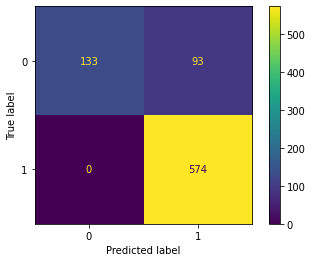

In [111]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(df2['prediction'], df2['identity_hate'])

cm_display = ConfusionMatrixDisplay(cm).plot()

## Overall accuracy on the real world data  0.8837, on training set our accuracy was : 0.9086